# Training a Dense NN to go learn the "Image Function"

## NN: pixel location features -> pixel value

### This lets the neural network be a "compression of the image"

In [1]:
import numpy as np
import torch
import torchsummary

import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

In [2]:
img = plt.imread('cat.jpg')
img = img.mean(axis=-1)
img = torch.from_numpy(img)
imgdown = img[::20, ::20]

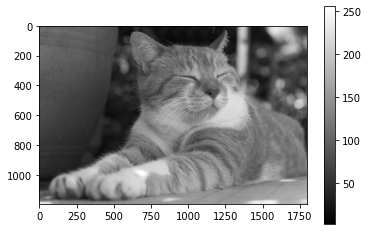

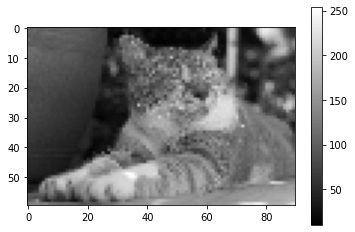

In [3]:
plt.imshow(img.numpy(), cmap='gray')
plt.colorbar();plt.show()
plt.imshow(imgdown.numpy(), cmap='gray')
plt.colorbar();plt.show()

## We give these features to the NN:
 - x coordinate (scaled)
 - y coordinate (scaled)
 - $\sin x, \cos x, \tan x, \sin y, \cos y, \tan y$
 - $\sin(xy), \cos(xy), \tan(xy)$
 - $\sin(x+y), \cos(x+y), \tan(x+y)$
 - $r = \sqrt{x^2+y^2}$
 - $r^2 = x^2+y^2$

In [4]:
def get_img_input(img):
    y_shape, x_shape = img.shape
    x = torch.linspace(-np.pi/2, np.pi/2, x_shape)
    y = torch.linspace(-np.pi/2, np.pi/2, y_shape)
    y, x = torch.meshgrid(y, x)

    sinx,cosx, tanx = torch.sin(x),torch.cos(x), torch.tan(x)
    siny,cosy, tany = torch.sin(y),torch.cos(y), torch.tan(y)
    sinxpy,cosxpy, tanxpy = torch.sin(x+y),torch.cos(x+y), torch.tan(x+y)
    sinxy,cosxy, tanxy = torch.sin(x*y),torch.cos(x*y), torch.tan(x*y)
    r, r2 = torch.sqrt(x**2+y**2),(x**2+y**2)

    X = torch.stack([x,y, sinx, cosx, tanx, siny, cosy, tany,
                     sinxy, cosxy, tanxy, sinxpy, cosxpy, tanxpy, r, r2], dim=-1)
    return X

In [5]:
get_img_input(imgdown).shape

torch.Size([60, 90, 16])

In [6]:
class Network(torch.nn.Module):
    def __init__(self, fcs_sizes, nonlin):
        super(Network, self).__init__()
        fcs_sizes = [16]+fcs_sizes+[1]
        self.fcs = []
        for fc1, fc2 in zip(fcs_sizes[:-1], fcs_sizes[1:]):
            self.fcs.append(torch.nn.Linear(fc1, fc2))
        self.fcs = torch.nn.ModuleList(self.fcs)
        self.nonlin = nonlin
    def forward(self, X):
        for fc in self.fcs[:-1]:
            X = fc(X)
            X = self.nonlin(X)
        return self.fcs[-1](X)
            
network = Network([50,50,50], torch.sigmoid)

X = torch.randn(100, 16)
Y = network(X)
print(Y.shape)


torch.Size([100, 1])


0


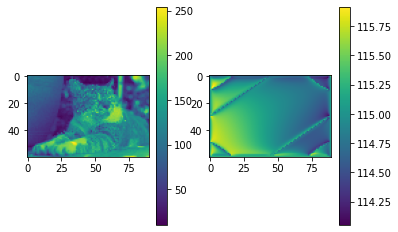

200


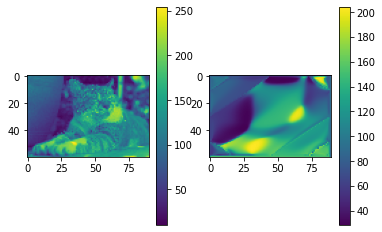

400


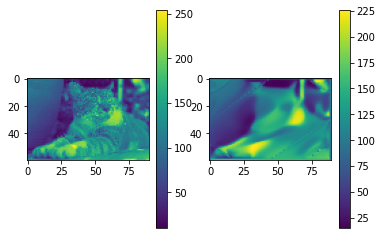

600


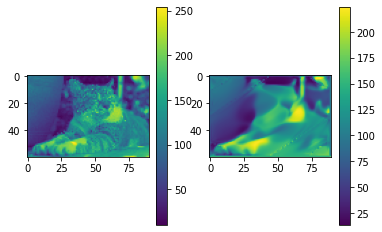

800


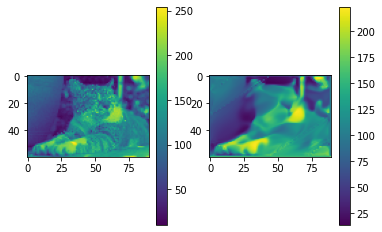

1000


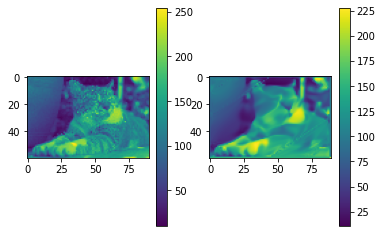

1200


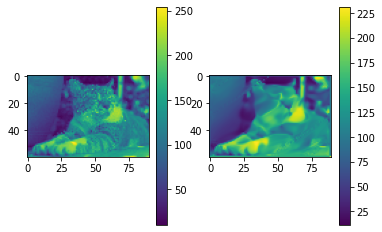

1400


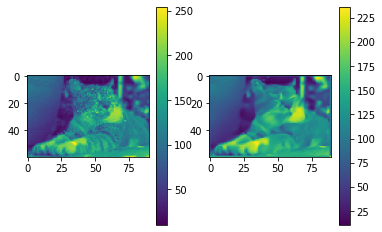

1600


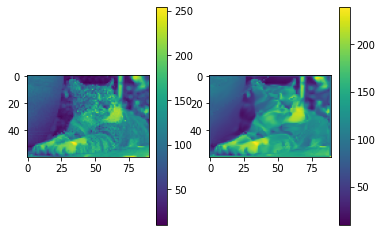

KeyboardInterrupt: 

In [8]:
# sigmoid does not work. tanh, relu does work
network = Network([50,50,50,50,50,50,50], torch.tanh)
opt = torch.optim.Adam(network.parameters(), lr=0.01)

Y_true = imgdown
X = get_img_input(Y_true)
for i in range(10000):
    Y = 255*torch.sigmoid(network(X))
    loss = (Y[:, :, 0]-Y_true).pow(2.).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i%200==0:
        print(i)
        plt.subplot(121);plt.imshow(Y_true.numpy());plt.colorbar()
        plt.subplot(122);plt.imshow(Y[..., 0].detach().numpy());plt.colorbar()
        plt.show()


## Final results: network does learn the overall shapes present, but does not generalize to details
### Training was done on low resolution image.
### Testing was done with full blown image.

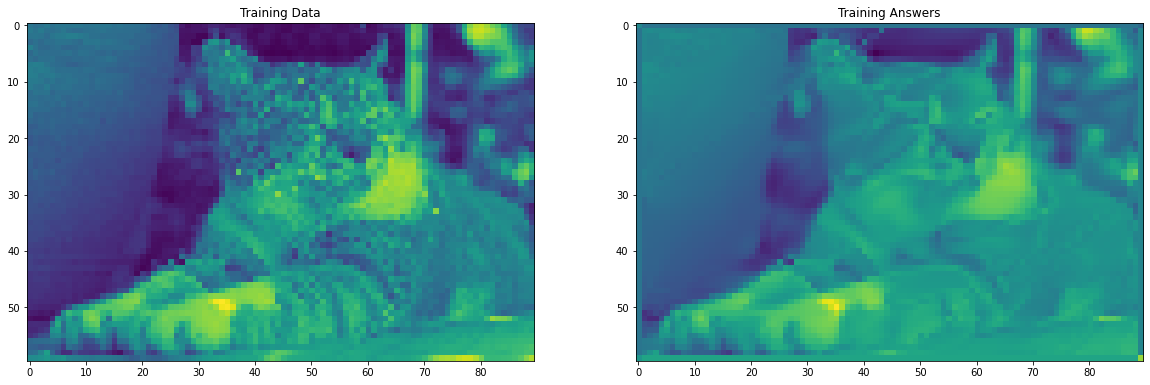

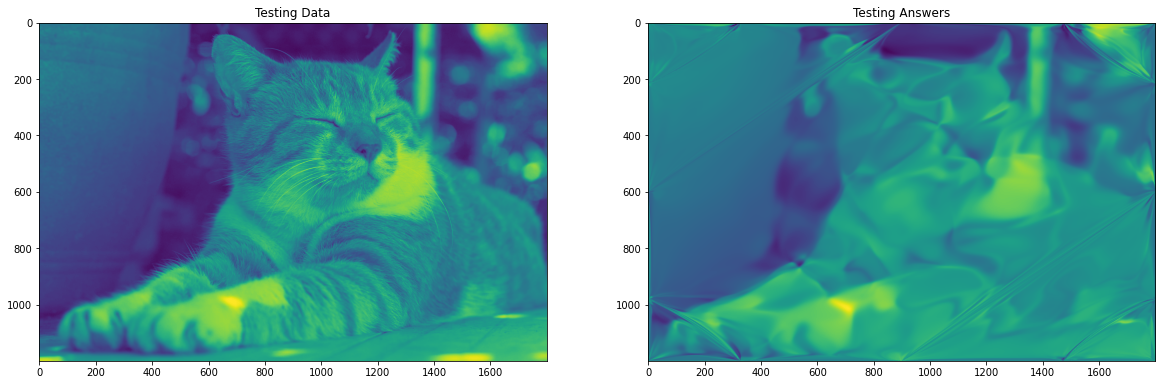

In [13]:
Y_true = imgdown
X = get_img_input(Y_true)
Y = network(X).detach().numpy()

plt.figure(figsize=(20,20))
plt.subplot(121);plt.imshow(Y_true);plt.title('Training Data')
plt.subplot(122);plt.imshow(Y);plt.title('Training Answers')
plt.show()
Y_true = img
X = get_img_input(Y_true)
Y = network(X).detach().numpy()

plt.figure(figsize=(20,20))
plt.subplot(121);plt.imshow(Y_true);plt.title('Testing Data')
plt.subplot(122);plt.imshow(Y);plt.title('Testing Answers')
plt.show()